In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

import os,sys
sys.path.insert(0,os.path.abspath(r"/home/mer49/Dropbox (Cambridge University)/OLeary/Code/"))
import neurotools
from neurotools.nlab import *

datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'

from util   import *
from basics import *
from simulate_data import *
from estimators    import *
from config import *
from scipy.special import *
configure_pylab()   

from functools import lru_cache as cache
from opt_einsum import contract

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# Shadow all pylab functions and numpy with the Jax versions
# Keep numpy around as np0 for easier RNG, array assignments
import jax
import jax.numpy as np
import numpy.random as npr
from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax import jacfwd, jacrev
from jax import lax
from jax.numpy.fft import *
from jax.numpy.linalg import *
fori = lax.fori_loop
def hess(f,inparam):
    return jacfwd(jacrev(f,inparam),inparam)
def hvp(f, x, v):
    return grad(lambda x: vdot(grad(f)(x), v))(x)
import numpy as np0

# redefine these with Jax env so it can be traced
def conv(x,K):
    return real(ifft2(fft2(x.reshape(L,L))*K))
def slog(x,minrate = 1e-10):
    return log(maximum(minrate,x))
def sexp(x,bound = 10):
    return exp(clip(x,-bound,bound))
from numpy.linalg import cholesky as chol
def logdetpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
def vec(X):
    return X.ravel()

In [32]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128+32        # Grid size
T      = L*L       # Total number of basis functions 

In [33]:
resolution = 5
# Settings for loop
pad = 0.6 # Pad to avoid wrap-around from circular convolution; 0.5=no padding
Fs  = 50.0 # Sample rate in Hz

# 2D grid coordinates as complex numbers
c = arange(L)-L//2
coords = 1j*c[:,None]+c[None,:]
bins   = linspace(0,1,L+1)

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
px_p_meter = 338
#dataset    = 'R18_20200131_1to2_EC_good.mat'
#dataset    = 'R11_20190607_1to2_EC_good.mat'
px_p_meter  = 350
dataset     = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]
dataset_ID  = re.match('(R\d+)_(\d+)',dataset).group(0)

# Use low-pass filtered velocity angle as heading 
# Positive dx is eastwards
# Negative dx is westwards
# Positive dy is .. northwards?
# Negative dy is .. southwards?
# Angle is computed as if a complex number
# So North is +90, West is ±180, South is -90, and East is 0
# sin(θ) is therefore the vertical direction
# with sin(θ)=1 being northwards
# Likewise cos(θ) is the horizontal direction
# with cos(θ)=1 being eastwards
# North: positive sin(θ)
# South: negative sin(θ)
# East : positive cos(θ)
# West : negative cos(θ)
# φ=0    is West
# φ=1/2π is South
# φ=π    is East
# φ=3/2π is North
φW = 0
φS = pi/2
φE = pi
φN = 3*pi/2
φs = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))
Fl = 0.25 # Low-frequency cutoff

In [34]:
# Load all datasets
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets  = len(xy50)

In [35]:

DODATASETS = range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta = np0.max([maxx-minx,maxy-miny])
scale = (1-1e-6)/(delta*pad*2)
x     = (x-(maxx+minx)/2+delta*pad)*scale
y     = (y-(maxy+miny)/2+delta*pad)*scale

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm per bin',cm_p_bin)

# Quick hack patching load dataset to use common alignment for all cells
def load_dataset(fn,dataindex,pad):
    # Get all datasets
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    hd50 = data['hd50'] # Head angle
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

cm per bin 2.534569882505151


In [36]:
def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

In [37]:
# Collect EW/NS field pairs from all cells 
all_EW = []
all_NS = []
all_all_maps = []

DOPLOTS = True
idata,dataindex = [*enumerate(DODATASETS)][0]

# Get specific dataset
s,x,y,scale = load_dataset(datadir+dataset,dataindex,pad)

# Grab spikes
st    = find(s>0)
xs,ys = x[st],y[st]
sk    = s[st]
N,K   = bin_spikes(x,y,s,bins)
y1    = nan_to_num(K/N)
mask  = blur(N>0,3)>0.1

In [38]:
# Calibrate grid scale
#λhat   = kdeλ(N,K,L/200)
λhat   = nan_to_num(K/N)
u = outer(hanning(L),hanning(L))
acorr2 = fft_acorr(λhat*u,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 50                     # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins    

print('P=',P)
fgσ  = P/pi
bgσ  = fgσ*2.5
λhat = kdeλ(N,K,fgσ)
λbg  = kdeλ(N,K,bgσ)

P= 10.68


In [39]:

# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()
y    = nan_to_num(K/N)
λhat = kdeλ(N,K,fgσ) # Foreground rate
λbg  = kdeλ(N,K,bgσ) # Background rate
lλh  = slog(λhat)    # Log rate
lλb  = slog(λbg)     # Log background

# Heuristic LGCP

In [40]:
fgσ  = P/pi
bgσ  = fgσ*5
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets
σ0   = zerolag(radial_acorr(lλf,mask))

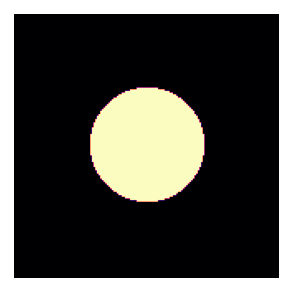

In [41]:
rP   = 2
rβ   = 10
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 21
Nβ   = 21
Ps   = exp(linspace(log(P_lo),log(P_hi),NP))
βs   = exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1]

@cache
def make_kernel_ft(L,P,σ0,dc=1e1,k=3):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

keep2d = zeros((L,L),dtype='bool')
for p in Ps:
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])/5
    keep2d |= (abs(Kf))>thr
showkn(keep2d)

In [42]:
keep2d   = keep2d | keep2d.T
keep     = where(keep2d.ravel())[0]
keep1d   = any(keep2d,axis=0)
elements = fft(eye(L),norm='ortho')[:,keep1d]
R1d      = sum(keep1d)
keepcut  = where(keep2d[:,keep1d][keep1d,:].ravel())[0]
R        = len(keep)
Rlt      = (R*(R+1))//2
down     = eye(T)[keep]

In [43]:
def reverse(A):
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())
def hcv(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
def hcm(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
def Ftv(v):  # Collapse vector DOWN
    return fhtv(v)[keep]
def Fv(v):
    return fhtv(zeros(T).at[keep].set(v))
def RI(x):
    return real(x)+imag(x)
def fhtv(v):
    return RI(fft2(v.reshape(L,L),norm='ortho').ravel())
def fhtA(x):
    return RI(fft2(x.reshape(x.shape[0],L,L),norm='ortho').reshape(x.shape[0],T))
def FtA(A):  # Collapse matrix DOWN
    return fhtA(A.T).T[keep,:]
def FA(A):  
    return fhtA(zeros((T,A.shape[-1])).at[keep,:].set(A).T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)
def chol(x):
    return jax.scipy.linalg.cholesky(x,lower=True)
def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(
        K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),
        axes=(0,1))).reshape(T,M.shape[-1])

In [44]:
μ0 = lλb.ravel()
μ  = lλf.ravel()
nλ = n*exp(μ+μ0)

def er(a,b): print(max(abs(a-b)))


# numpy's fft is faster
from numpy.fft import *

def fast_low_rank_inverse_covariance(nλ,β,Λr):
    X  = contract('ij,ik,jl->klij',sqrt(nλ).reshape(L,L),elements,elements)
    X  = real(X) + imag(X)
    X  = X.reshape(R1d*R1d,L*L)[keepcut]
    return Λr*β + X@X.T

def fast_low_rank_covariance(nλ,β,Λr):
    Λp = fast_low_rank_inverse_covariance(nλ,β,Λr)
    A  = ltinv(chol(Λp))
    return A.T@A

def fast_inverse_diagonal(nλ,β,Λr):
    Λp = fast_low_rank_inverse_covariance(nλ,β,Λr)
    A  = ltinv(chol(Λp))
    A  = zeros((R,T)).at[:,keep].set(A).reshape(R,L,L)
    DF = RI(fft2(A,norm='ortho').reshape(R,T))
    v2 = sum(DF**2,0)
    return v2

#@cache
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,σ0)
    Λf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = RI(Kf).ravel()[keep]
    Λh = RI(Λf).ravel()[keep]
    sK = sum(log(Kf[keep2d]))
    nK = sum(keep2d)
    Λr = hcm(Λh,eye(R))
    print('prepared kernel with radius',p)
    return K0,Kf,Λf,Kh,Λh,sK,nK,Λr

def loss(μ,v,β,p):
    '''
    n' [ λ - y∘μ ] + ½ μ' Λ₀ μ  + ½ ln|Σ₀| - ½ ln |Σ| + ½ tr[Λ₀ Σ]
    
    λ    = exp(μ + μ0 + v/2)
    nλ   = n*λ
    lnΣ0 = (sK-nK*log(β))/2
    Σ    = fast_low_rank_inverse_covariance(nλ,β)
    return n@(λ-y*μ), μ@ cv(Λf, μ)/2  , lnΣ0/2 , -logdet(Σ)/2 , trace(Λr@Σ)/2
    '''
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    nK = len(keep)
    sK = sum(log(abs(Kf)))
    
    # We should work in low rank subspace
    μh   = Ftv(μ)
    μ    = Fv(μh)
    λ    = exp(μ + μ0 + v/2)
    nλ   = n*λ
    #lnΣ0 = sK-nK*log(β)
    lnΣ0 = -logdet(β*Λr)
    Σr   = fast_low_rank_covariance(nλ,β,Λr)
    return n@(λ-y*μ), μh@ hcv(β*Λh, μh)/2  , lnΣ0/2 , -logdet(Σr)/2 , trace(β*Λr@Σr)/2

def infer(μ,v,β,p,maxiter=100,tol=1e-6):
    β = float(β)
    p = float(p)
    
    K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(p)
    
    # Prepare gradient and hessian operators
    M  = cop(Kf)
    Λ0 = cop(Λf)
    J  = lambda μ: β*Λ0@μ + n*(exp(μ+μ0)-y)
    H  = lambda μ: β*Λ0   + diagop(n*exp(μ+μ0))
    
    for j in range(maxiter):
        Δ = -minres(H(μ),J(μ),tol=1e-7,M=M)[0]
        μ += Δ
        if max(abs(Δ))<tol: break
    #print(max(abs(Δ)))
    nλ = n*exp(μ + μ0)
    v  = fast_inverse_diagonal(nλ,β,Λr)
    
    for i in range(maxiter):
        J  = lambda μ: β*Λ0@μ + n*(exp(μ+μ0+v/2)-y)
        H  = lambda μ: β*Λ0   + diagop(n*exp(μ+μ0+v/2))
        for j in range(10):
            Δμ = -minres(H(μ),J(μ),tol=1e-6,M=M)[0]
            μ += Δμ
            if max(abs(Δμ))<tol: break
        nλ = n*exp(μ + μ0 + v/2)
        v2 = fast_inverse_diagonal(nλ,β,Λr)
        Δv = v2-v
        v += Δv
        #print('v',max(abs(Δv)))
        #print('μ',max(abs(Δμ)))
        if max(abs(Δμ))<tol and max(abs(Δv))<tol: break
        
    return μ,v,sum(array(loss(μ,v,β,p)))

v = μ*0
β = 1.291549665
μ,v,l = infer(μ,v,β,P)

prepared kernel with radius 10.68
prepared kernel with radius 10.68


In [45]:
μ1,v1,l1 = infer(μ,v,β,13)
μ2,v2,l2 = infer(μ,v,β,8)


prepared kernel with radius 13.0
prepared kernel with radius 13.0
prepared kernel with radius 8.0
prepared kernel with radius 8.0


In [46]:
l1,l2

(DeviceArray(31553.4696031028, dtype=float64),
 DeviceArray(31291.5268330191, dtype=float64))

In [47]:
allclose(μ1,μ2)

DeviceArray(False, dtype=bool)

prepared kernel with radius 8
prepared kernel with radius 13


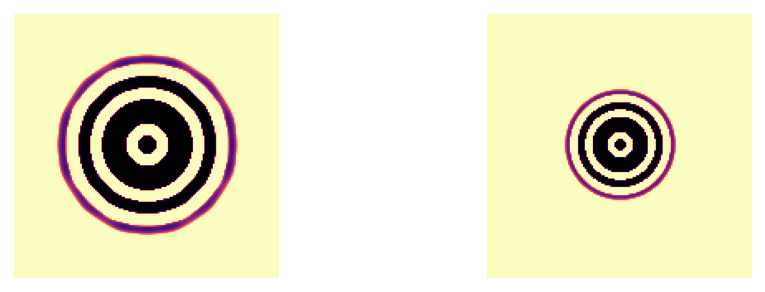

In [48]:
K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(8)
subplot(121)
showkn(Λf)
K0,Kf,Λf,Kh,Λh,sK,nK,Λr = prepare_kernel(13)
subplot(122)
showkn(Λf)

In [49]:
for i in range(8):
    print(allclose(prepare_kernel(8)[i],prepare_kernel(12)[i]))

prepared kernel with radius 8
prepared kernel with radius 12
False
prepared kernel with radius 8
prepared kernel with radius 12
False
prepared kernel with radius 8
prepared kernel with radius 12
False
prepared kernel with radius 8
prepared kernel with radius 12
False
prepared kernel with radius 8
prepared kernel with radius 12
False
prepared kernel with radius 8
prepared kernel with radius 12
False
prepared kernel with radius 8
prepared kernel with radius 12
True
prepared kernel with radius 8
prepared kernel with radius 12
False


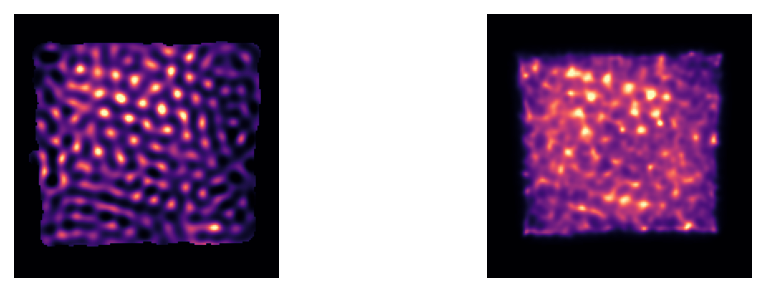

In [50]:
subplot(121)
λ = exp(μ + μ0 + v/2)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)

In [51]:
'''
βs = exp(linspace(log(0.1),log(10),10))
results = []
for β in progress_bar(βs):
    μ,v,l = infer(μ,v,β,P)
    results.append((μ,v,l))
μ,v,l = map(array,zip(*results))
for ai,a in enumerate(l.T):
    plot(βs,(a-mean(a)),label="n'[λ-y∘μ] ½μ'Λ₀μ ½ln|Σ₀| ½ln|Σ| ½tr[Λ₀Σ]".split()[ai])
ll = sum(l,1)
plot(βs,(ll-mean(ll)),label='sum',color='k')
legend()
semilogx()
axvline(1)
''';

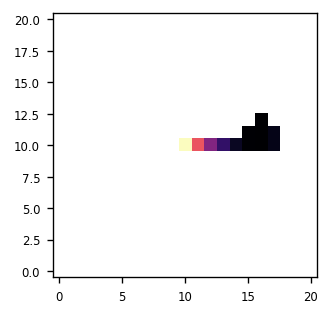

P[10]=10.68 β[16]=0.25


(DeviceArray([0.0164289872, 0.0308018377, 0.0421300783, ..., 0.0363428912,
              0.030367574 , 0.029921094 ], dtype=float64),
 DeviceArray([0.2027190998, 0.2027122625, 0.2027020635, ..., 0.2026875697,
              0.2026892015, 0.2026872554], dtype=float64),
 DeviceArray(31142.8956496448, dtype=float64))

In [54]:
from IPython.display import clear_output

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,v,l = infer(μ,v,float(β),float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,vref = μ,v

results = np0.empty((NP,Nβ),dtype='object')
def current_best():
    global results
    losses  = array([inf if r is None else r[2] for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]  
def search(ip,iβ):
    global results
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return
    if results[ip,iβ]: return
    # Extrapolate when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = μ1 + μ1 - μ2
        v = v1 + v1 - v2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,v1),(μ2,v2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = μ1 + μ1 - μ2
        v = v1 + v1 - v2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,v = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,v = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,v = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,v = results[ip-1,iβ][:2]
    else: μ,v = μref,vref
    β = βs[iβ]
    μ,v,l = infer(μ,v,float(β),float(p))
    results[ip,iβ] = (μ,v,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],l))
    clear_output(wait=True)
    figure()
    imshow(array([r[2] if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    search_order = [(0,1),(0,-1),(1,0),(-1,0)]
    for Δp,Δβ in search_order:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ)
    return

ip = NP//2
iβ = Nβ//2
search(ip,iβ);

Optimized kernel height β=0.251189
Optimized kernel period P=11.446541


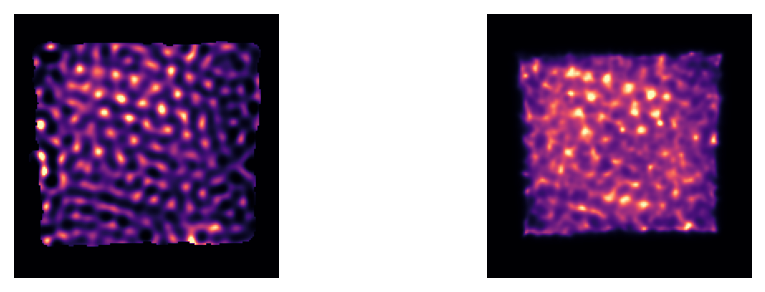

In [63]:
bestP, bestβ = current_best()[:2]
μ,v,l = results[bestP,bestβ]
λ = exp(μ + μ0 + v/2)
subplot(121)
showim(λ.reshape(L,L),mask=mask)
subplot(122)
showim(1/v.reshape(L,L),mask=mask)
print('Optimized kernel height β=%f'%βs[bestβ])
print('Optimized kernel period P=%f'%Ps[bestP])

Optimized kernel height β=0.251189
Optimized kernel period P=11.446541
